In [1]:
# run instead of import to be able to serialize the functions and send them to the workers
# otherwise one would need to upload the file explicitely for each worker
%run utils.py

In [2]:
from ipywidgets import FileUpload
upload = FileUpload()
display(upload)

FileUpload(value={}, description='Upload')

In [13]:
setup_rucio_and_proxy(upload.data[-1], rucio_account="nihartma")

In [14]:
import physlite_experiments
from physlite_experiments.physlite_events import physlite_events
from physlite_experiments.analysis_example import get_obj_sel
from physlite_experiments.io import AIOHTTPSource
from physlite_experiments.utils import subdivide
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import rucio.client
from tqdm.auto import tqdm
import requests

import io
import math
import gc
import time
from functools import partial

import dask
from dask import delayed
from dask.distributed import performance_report, wait, fire_and_forget, futures_of

first, list the filenames:

In [15]:
rucio_client = rucio.client.Client()

In [16]:
files = list(rucio_client.list_files("data17_13TeV", "data17_13TeV.periodK.physics_Main.PhysCont.DAOD_PHYSLITE.grp17_v01_p4309"))

In [17]:
files[0]

{'scope': 'data17_13TeV',
 'name': 'DAOD_PHYSLITE.22958312._000001.pool.root.1',
 'bytes': 339098731,
 'adler32': 'ea4a58e1',
 'guid': '9182E93759873A4BA6ABC72E1C286873',
 'events': 42870}

In [18]:
url = get_signed_url(rucio_client, files[0]["scope"], files[0]["name"])

The analysis can be run on data directly downloaded into memory or via asyncio and 100 parallel connections:

In [19]:
def download(url):
    return requests.get(url).content

In [20]:
data = download(url)

In [21]:
class Source(AIOHTTPSource):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, tcp_connection_limit=100, **kwargs)

In [22]:
rootfile = uproot.open(url, http_handler=Source)

In [23]:
tree = rootfile["CollectionTree"]

In [24]:
events = physlite_events(tree)

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau80_medium1_tracktwo_L1TAU60_tau35_medium1_tracktwo_L1TAU12IM_L1TAU60_DR-TAU20ITAU12IAuxDyn.TrigMatchedObjects


In [25]:
events.Electrons.pt

<Array [[], [], [], [], ... [], [4.81e+03], []] type='42870 * var * float32'>

This is the actual analysis part, it runs some object selections on Electrons, Muons, Jets with overlap removal and adds `baseline`, `signal` and `passOR` fields.

In [26]:
events_decorated = get_obj_sel(events)

/srv/conda/envs/notebook/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


In this version i forgot to add the muon mass, so let's add it to do some dilepton invariant mass plots:

In [27]:
events_decorated["Muons", "m"] = 105.6583715

In [28]:
leptons = ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")

In [29]:
l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))

In [30]:
m = (l1 + l2).mass
m = ak.flatten(m, axis=None)
m = ak.to_numpy(m)

Dilepton invariant mass for signal leptons - the Upsilon and the Z peak are visible already from one file:

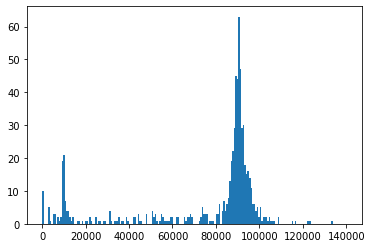

In [31]:
plt.hist(m, bins=200, range=(0, 140000));

let's wrap it into a single function that takes the binary data and outputs an arrow buffer for the lepton 4-momenta and the object selection flags:

In [32]:
def get_leptons(url, max_chunksize=100000):
    with uproot.open(url, http_handler=Source) as f:
        tree = f["CollectionTree"]
        entry_start = 0
        leptons = []
        n = tree.num_entries
        for chunksize in subdivide(n, math.ceil(n / max_chunksize)):
            entry_stop = entry_start + chunksize
            events = physlite_events(tree, entry_start=entry_start, entry_stop=entry_stop)
            entry_start = entry_stop
            events_decorated = get_obj_sel(events)
            events_decorated["Muons", "m"] = 105.6583715
            leptons.append(
                ak.concatenate([events_decorated.Electrons, events_decorated.Muons], axis=1)
            )
        leptons = ak.concatenate(leptons)
        leptons = ak.to_arrow(leptons[["pt", "eta", "phi", "m", "passOR", "baseline", "signal"]])
        gc.collect()
    gc.collect()
    return leptons

In [33]:
%%time
l = ak.from_arrow(get_leptons(url, max_chunksize=100000))

Skipping EventInfoAuxDyn.streamTagRobs
Skipping EventInfoAuxDyn.streamTagDets
Can't interpret PrimaryVerticesAuxDyn.neutralParticleLinks
Skipping AnalysisHLT_mu14_ivarloose_tau25_medium1_tracktwo_L1DR-MU10TAU12I_TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_e17_lhmedium_nod0_ivarloose_tau25_medium1_tracktwo_L1DR-EM15TAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_03dR30_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau35_medium1_tracktwo_tau25_medium1_tracktwo_tautsf_L1DR-TAU20ITAU12I-J25AuxDyn.TrigMatchedObjects
Skipping AnalysisHLT_tau80_medium1_tracktwo_L1TAU60_tau35_medium1_tracktwo_L1TAU12IM_L1TAU60_DR-TAU20ITAU12IAuxDyn.TrigMatchedObjects
CPU times: user 9.4 s, sys: 996 ms, total: 10.4 s
Wall time: 12.4 s


In [34]:
len(l)

42870

And then run it on dask on all files:

In [35]:
# local cluster:
#from dask.distributed import Client

#client = Client(n_workers=8, threads_per_worker=1)
#client

In [36]:
#client.shutdown()

In [27]:
# enter proxy/8787 in field on the left

In [28]:
#client.restart()

In [6]:
# gateway cluster
from dask_gateway import GatewayCluster
cluster = GatewayCluster(
    worker_cores=1,
    worker_memory=3.5,
    image="eu.gcr.io/gke-dev-311213/jupyter-physlite:20210709"
)

In [7]:
cluster

In [86]:
#cluster.scale(100)
#cluster.scale(50)
cluster.scale(360)

In [98]:
cluster.shutdown()

In [46]:
client = cluster.get_client()

In [85]:
#client.restart()

In [42]:
# not quite sure why i need to wrap it (will give pickle error otherwise ..)
partial_get_signed_url = partial(get_signed_url_worker, upload.data[-1], rucio_account="nihartma", rucio_home='/srv/conda/envs/notebook')

In [43]:
def run_task(file):
    url = partial_get_signed_url(
        file["scope"],
        file["name"],
    )
    t = time.time()
    leptons = get_leptons(url, max_chunksize=50000)
    log = (len(leptons), time.time() - t)
    return leptons, log

In [44]:
def merge(results):
    lepton_list = []
    log_list = []
    for leptons, log in results:
        lepton_list.append(leptons)
        log_list.append(log)
    return lepton_list, log_list

build the task graph:

In [47]:
fut = client.submit(run_task, files[0])

In [48]:
fut.result()[1]

(42870, 13.038016319274902)

In [49]:
len(files)

25399

In [87]:
sub_tasks = []
tasks = []
for file in files:
    d_task = delayed(run_task)(file)
    sub_tasks.append(d_task)
    if len(sub_tasks) > 9:
        d_merge = delayed(merge)(sub_tasks)
        tasks.append(d_merge)
        sub_tasks = []

In [88]:
len(sub_tasks)

9

In [89]:
tasks = dask.persist(*tasks)

In [56]:
a_logs = dask.compute(*[t[1] for t in tasks if futures_of(t)[0].status == "finished"])

In [59]:
events_times = np.concatenate(a_logs)

In [99]:
events_times[:, 0].sum() / events_times[:, 1].sum()

2585.8219261004174

In [68]:
def get_mass(leptons, selection="all"):

    def get_mass_single(leptons):
        leptons = ak.from_arrow(leptons)
        leptons = ak.with_parameter(leptons, "__record__", "xAODParticle")
        if selection == "all":
            l1, l2 = ak.unzip(ak.combinations(leptons, 2))
        elif selection == "signal":
            l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.signal & leptons.passOR], 2))
        elif selection == "baseline":
            l1, l2 = ak.unzip(ak.combinations(leptons.mask[leptons.baseline & leptons.passOR], 2))
        l1, l2 = [ak.with_parameter(i, "__record__", "xAODParticle") for i in [l1, l2]]
        m = (l1 + l2).mass
        m = ak.flatten(m, axis=None)
        m = ak.to_numpy(m)
        return m
    
    if isinstance(leptons, list):
        m = []
        for leptons_i in leptons:
            m.append(get_mass_single(leptons_i))
        return np.concatenate(m)
    
    return get_mass_single(leptons)

In [90]:
delayed_leptons = dask.persist(*[t[0] for t in tasks if futures_of(t)[0].status == "finished"])

In [91]:
len(delayed_leptons)

2539

In [92]:
len(tasks)

2539

In [93]:
m_list_all = dask.compute(*[delayed(partial(get_mass, selection="all"))(i) for i in delayed_leptons])

In [94]:
m_list_baseline = dask.compute(*[delayed(partial(get_mass, selection="baseline"))(i) for i in delayed_leptons])

In [95]:
GeV = 1000

/tmp/ipykernel_88/1991371692.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1e7)


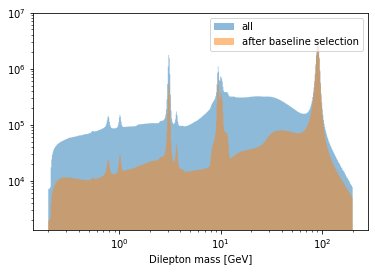

In [97]:
opts = dict(
    bins=np.geomspace(0.2, 200, 500),
    histtype="stepfilled", alpha=0.5
)
plt.hist(np.concatenate(m_list_all) / GeV, label="all", **opts);
plt.hist(np.concatenate(m_list_baseline) / GeV, label="after baseline selection", **opts);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Dilepton mass [GeV]")
plt.legend()
plt.ylim(0, 1e7)
plt.savefig("m2l_baseline_10percent.pdf")